# INSTRUCTIONS PROVIDED:

## PRODUCTION:
Dataset containing PLC information on the processing settings at COIL-DATE-MT level.
1. `COIL ID`: of the metal coil processed
1. `MT`:meter observation of the coil (i.e. one observation every 7 meters)
1. `DATE`: day of the year in which the processing of a given COIL-MT started
1. `TIME_START_PROCESS`: time in which the processing started 
1. All the remaining fields are settings refering to the processing of a given COIL-MT.

Hint: check the reliability of the MT variable.

## DEFECTS:
Dataset containing information on the detected defect by coil and type of defect.

This information are gathered during quality control processes after the production.
1. `COIL ID`: of the metal coil processed
1. `MT_FROM`: point of the coil in which a given defect start.
1. `MT_TO`: point in which a given defect end.
1. `DATE`: date in which the coil has been processed.
1. `DIF_TIPO_1`(to6): indicator for the kind of of defect detected.

In [1]:
#imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, make_scorer, hamming_loss, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Memory
from sklearn.multioutput import MultiOutputClassifier
import csv
from xgboost import XGBClassifier
random_state = 42
test_size = 0.4
cachedir = Memory(location='cache_directory', verbose=0)

In [2]:
#loading data
path_production= '/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_PRODUCTION_clean.csv'
path_defects='/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_DEFECTS_clean.csv'
production = pd.read_csv(path_production)
defects = pd.read_csv(path_defects, sep=';')

Creating the `MT_REVIEWED` column and substitute with the `MT` for correcting the data issues

In [3]:
production.sort_values(by=['COIL', 'DATE', 'TIME_START_PROCESS'], inplace=True)
production['MT_REVIEWED'] = production.groupby(['COIL'])['MT'].transform(lambda x: np.arange(start=0, stop=len(x)*7, step=7))
production.drop(columns=['MT'], inplace=True)
column_change=production.pop('MT_REVIEWED')
production.insert(2, 'MT_REVIEWED',column_change)
production.head()

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,240627,2019-03-15,0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,7,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,21,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,28,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


## Merging 2 dataframes
For the merging we looked for keeping all the rows of the production df

In [4]:
# This code creates the new dataframe with the defect information applied to the relevant meter ranges.
merged_df = production.copy()
for i in range(1, 7):
    defect_col = f'DIF_TIPO_{i}'
    merged_df[defect_col] = 0 # or use np.nan, or 0, depending on how you want to represent no defect

def apply_defects(row, production, merged_df):
    coil_id = row['COIL']
    mt_from = row['MT_FROM']
    mt_to = row['MT_TO']
    defect_info = row[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']]
    
    # Filter production for the current coil and meter range
    mask = (production['COIL'] == coil_id) & (production['MT_REVIEWED'] >= mt_from) & (production['MT_REVIEWED'] <= mt_to)
    production_subset = production.loc[mask]
    
    # Update the merged DataFrame with defect information
    for index in production_subset.index:
        merged_df.loc[index, defect_info.index] = defect_info.values

# Apply defects to the production DataFrame
_=defects.apply(lambda row: apply_defects(row, production, merged_df), axis=1)

## Dropping rows with NaN values in features

In [5]:
defect_columns = ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']
merged_df['DEFECT'] = merged_df[defect_columns].any(axis=1).astype(int)
print(merged_df.shape)
merged_df['DEFECT'].sum()

(299384, 117)


106132

In [6]:
nan_counts = merged_df.isnull().sum()
columns_with_nans = nan_counts[nan_counts > 0].index.tolist()
dropped_df = merged_df.dropna(subset=columns_with_nans)
dropped_df

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6,DEFECT
170,243941,2019-03-06,28,00:02:59.070,23.610352,1273.28850,1279.944000,1281.003750,1280.850750,1313.777250,...,0.035063,0.258854,0.134993,0,0,0,0,0,0,0
171,243941,2019-03-06,35,00:03:14.070,23.570531,1272.81000,1280.896875,1282.756875,1280.227500,1310.394375,...,0.026615,0.258924,0.135011,0,0,0,0,0,0,0
172,243941,2019-03-06,42,00:03:44.070,23.591655,1272.04650,1280.596500,1283.728500,1280.731500,1309.549500,...,0.034612,0.258888,0.135006,0,0,0,0,0,0,0
173,243941,2019-03-06,49,00:03:59.070,23.583060,1270.78875,1279.190250,1284.021000,1280.661750,1308.818250,...,0.039367,0.258924,0.135024,0,0,0,0,0,0,0
174,243941,2019-03-06,56,00:04:14.070,23.594212,1269.96750,1277.968125,1284.232500,1281.303750,1308.823125,...,0.038277,0.258899,0.135018,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299365,6838679,2019-04-19,749,10:46:32.860,8.932843,1271.34000,1277.043750,1259.679375,1262.975625,1276.233750,...,0.034937,0.258947,0.135017,0,0,0,0,0,0,0
299366,6838679,2019-04-19,756,10:47:32.860,8.948430,1267.99875,1278.011250,1261.586250,1267.042500,1278.022500,...,0.038531,0.258911,0.134953,0,0,0,0,0,0,0
299367,6838679,2019-04-19,763,10:48:17.860,8.951884,1269.88875,1279.816875,1264.786875,1270.957500,1283.366250,...,0.038778,0.258913,0.135053,0,0,0,0,0,0,0
299368,6838679,2019-04-19,770,10:49:17.860,8.977444,1266.59250,1280.936250,1265.782500,1271.475000,1285.683750,...,0.035091,0.258892,0.135005,0,0,0,0,0,0,0


In [7]:
X=dropped_df.loc[:, 'SPEED_PROCESS':'FILL_BENDING_NEG']
print(X.shape)
X.head()

(260638, 106)


,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,TEMP_Z6,PYRO_1_PRECHMBR,PYRO_2_FRST_3_ZONE,PYRO_3_LST_3_ZONE,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
170,23.610352,1273.28850,1279.944000,1281.003750,1280.85075,1313.777250,1287.848250,867.159450,1100.796300,1143.731250,...,0.000000,0.000000,0.000,4244.88375,7.752319,198.895500,1224.57375,0.035063,0.258854,0.134993
171,23.570531,1272.81000,1280.896875,1282.756875,1280.22750,1310.394375,1286.454375,866.311688,1100.555063,1142.737500,...,0.000000,19.993500,21.375,4242.94875,12.563663,231.608250,1282.89375,0.026615,0.258924,0.135011
172,23.591655,1272.04650,1280.596500,1283.728500,1280.73150,1309.549500,1284.502500,860.741550,1100.221200,1137.415500,...,530.302500,21.352500,21.375,4243.57875,12.157837,221.544375,1290.66000,0.034612,0.258888,0.135006
173,23.583060,1270.78875,1279.190250,1284.021000,1280.66175,1308.818250,1283.818500,855.048825,1107.692775,1140.646500,...,531.106875,21.231000,21.375,4244.62500,11.856412,224.306625,1289.47875,0.039367,0.258924,0.135024
174,23.594212,1269.96750,1277.968125,1284.232500,1281.30375,1308.823125,1284.369375,855.170625,1099.023750,1143.309375,...,530.163000,20.293537,21.375,4243.79250,11.638350,212.985000,1326.22875,0.038277,0.258899,0.135018


Dropping columns with 0 variance

## DROPPING FEATURES with correlation

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


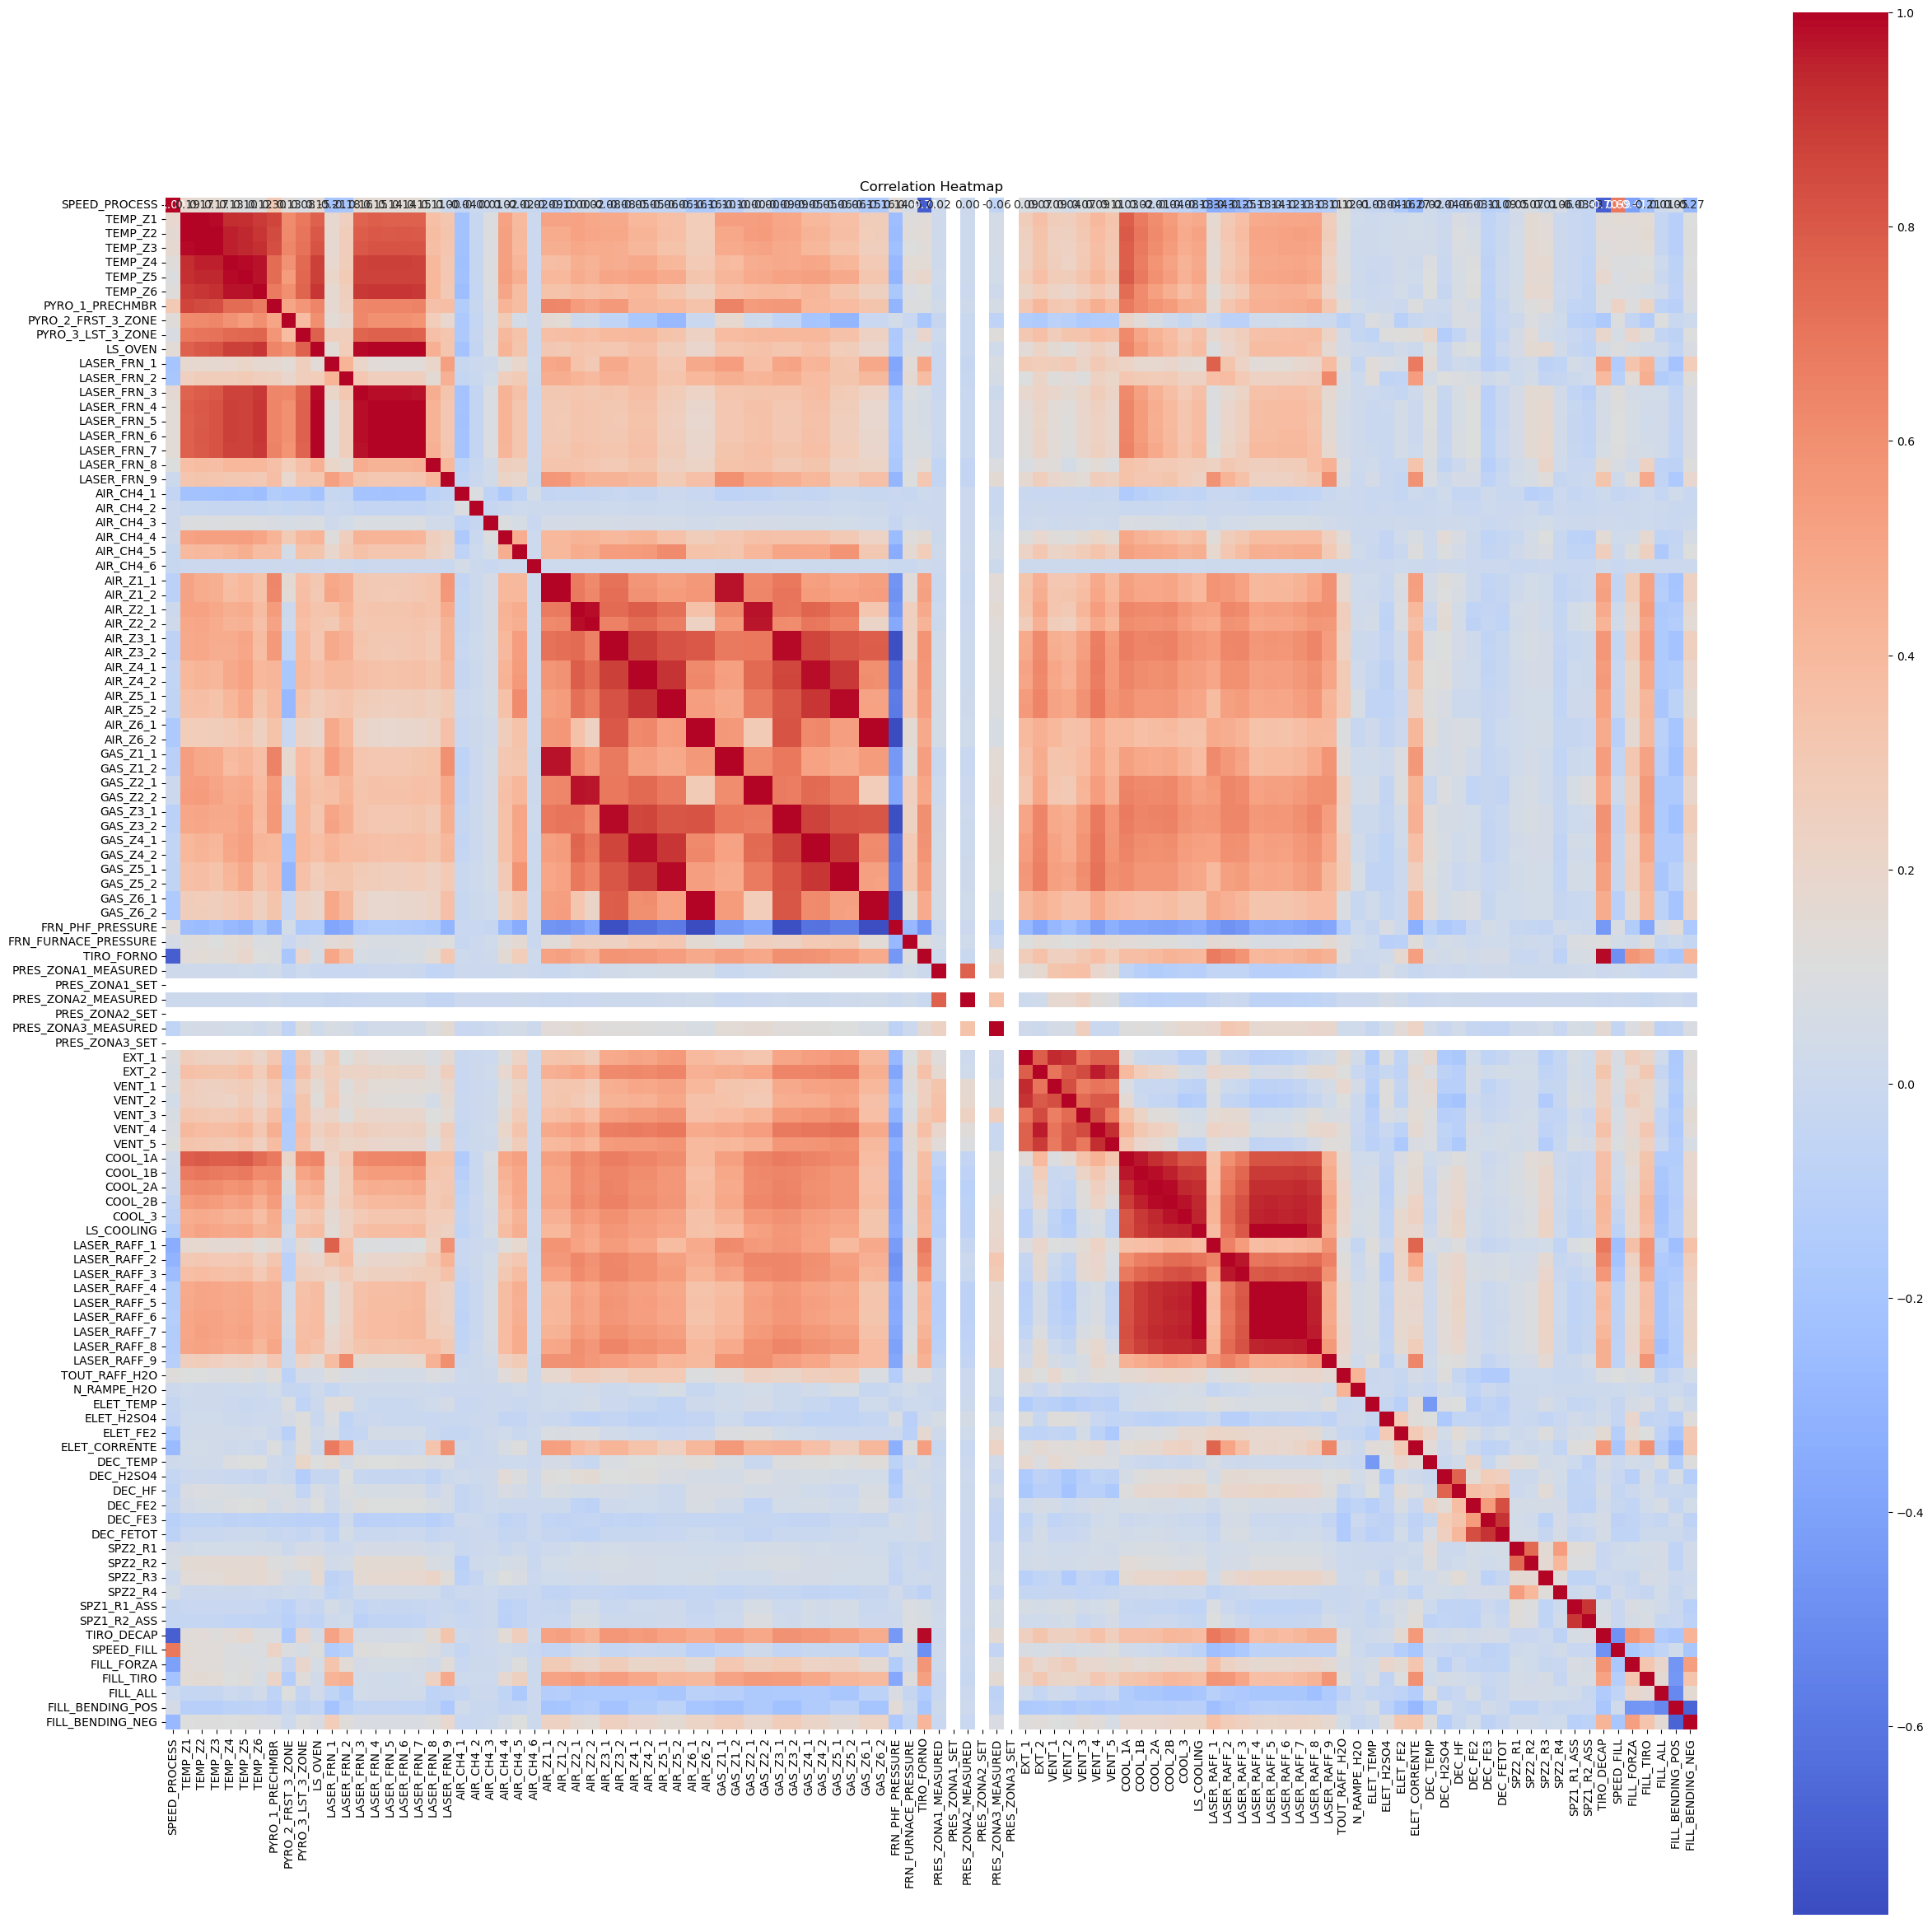

In [8]:
corr_matrix = X.corr()
plt.figure(figsize=(30, 30))  # You can adjust the size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
corr_matrix = X.corr().abs()  # Take absolute value to consider both positive and negative correlations

# Step 2: Set a correlation threshold
threshold = .75

# Step 3: Identify highly correlated pairs
# We use a mask to avoid duplication and self-correlation (correlation of a feature with itself)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 4: Choose features to drop (we'll drop one of each pair)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Step 5: Drop the features
X_reduced = X.drop(columns=to_drop)
X_reduced = X_reduced.drop(['PRES_ZONA3_SET', 'PRES_ZONA1_SET', 'PRES_ZONA2_SET'], axis=1)
X_reduced.shape

(260638, 43)

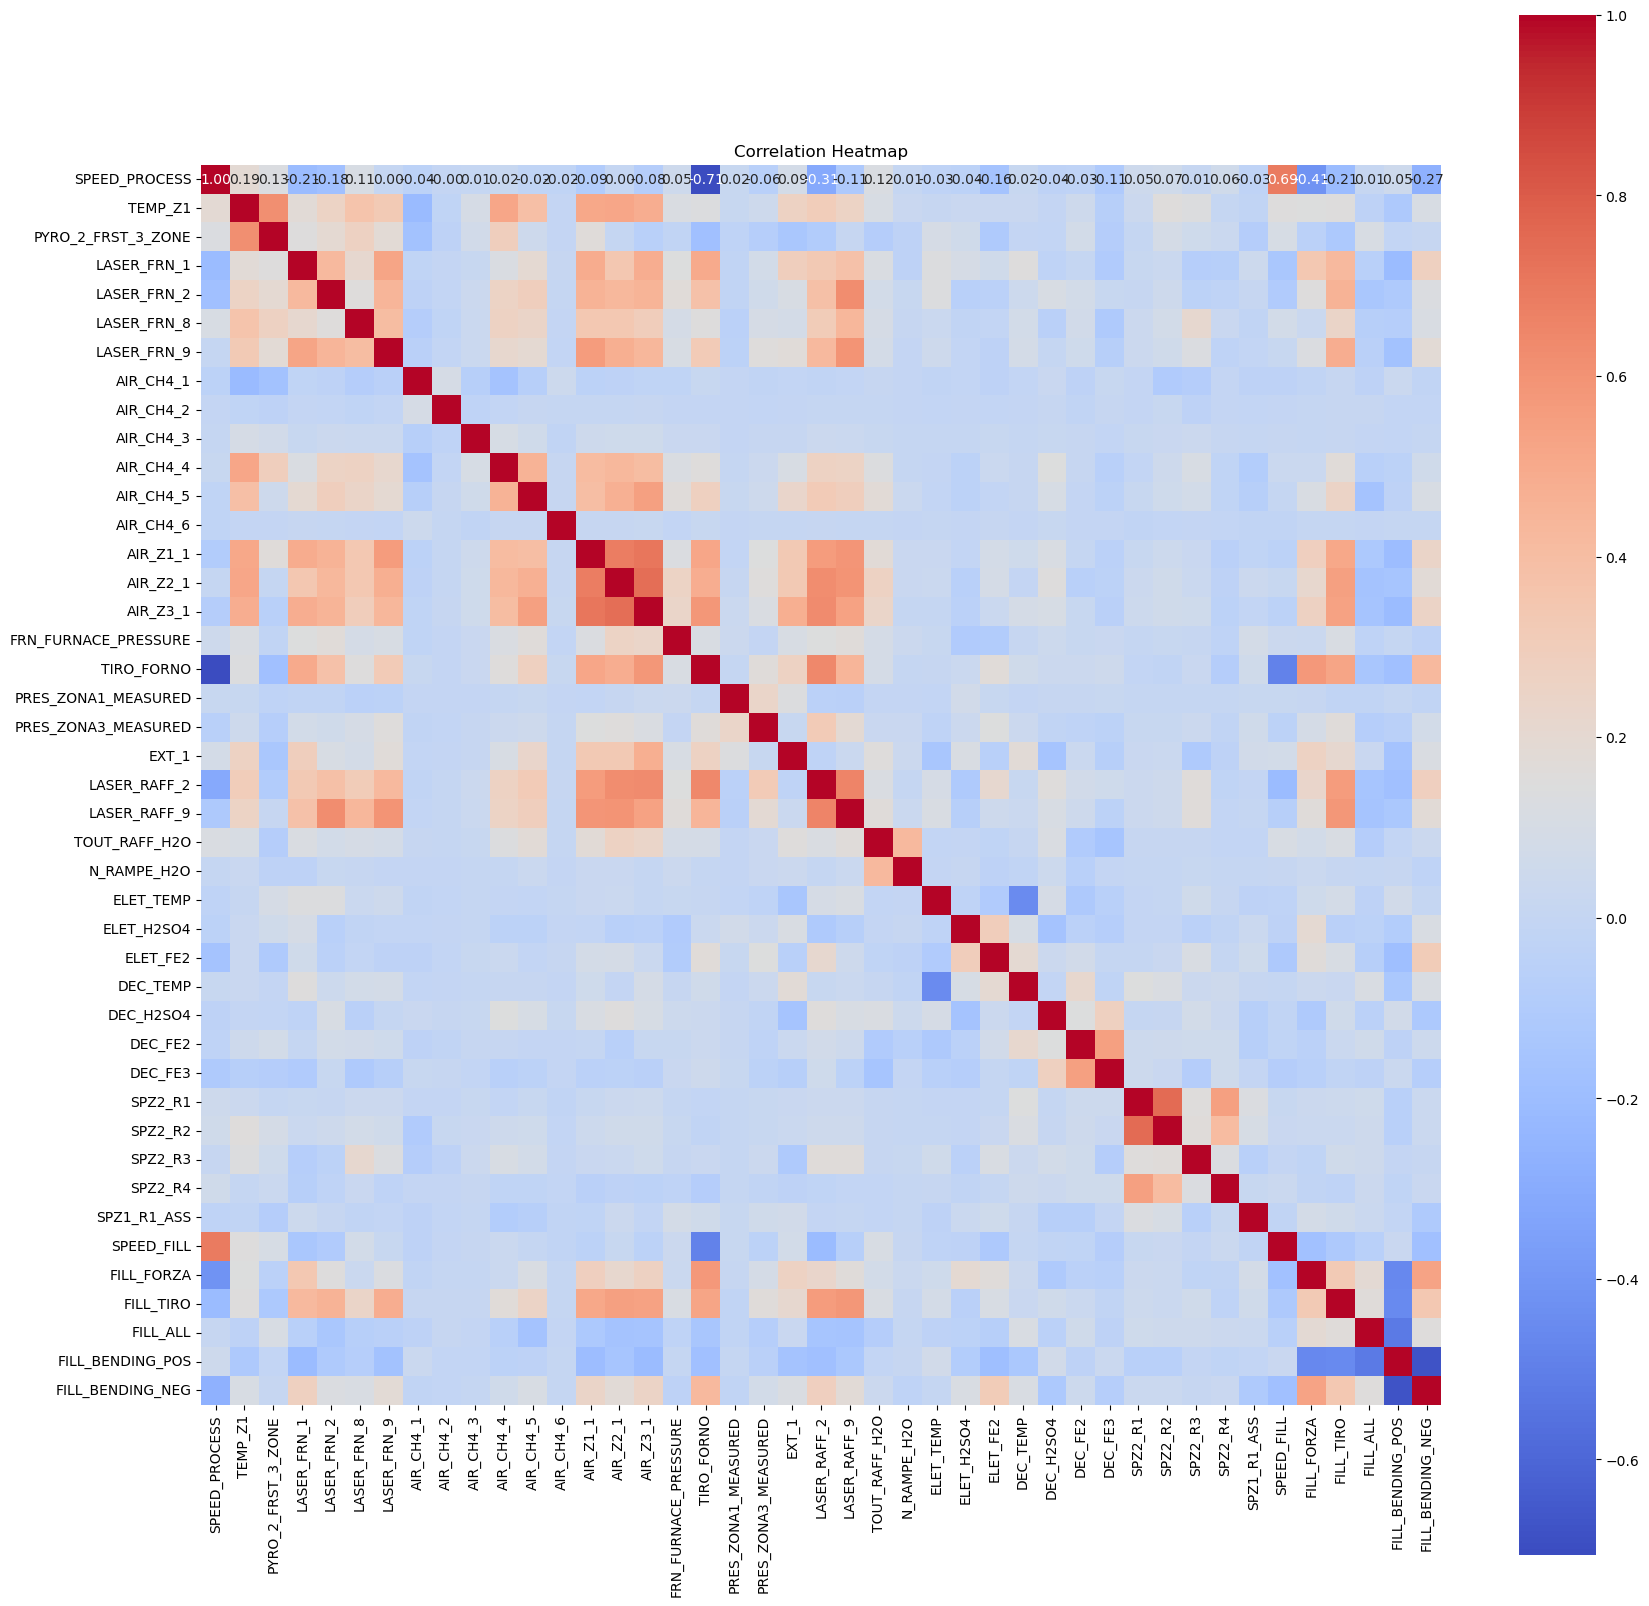

In [10]:
corr_matrix = X_reduced.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))  # You can adjust the size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.show()

## Splitting into Training, Validation and Test

In [13]:
target_columns = ['DEFECT']

X = X_reduced
y = dropped_df[target_columns]
print(X.shape)
print(y.shape)
grouped = dropped_df.groupby('COIL').groups

grouped_indices = [grouped[key] for key in grouped]

train_indices, temp_indices = train_test_split(grouped_indices, test_size=0.4, random_state=42)

validate_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_indices = [index for sublist in train_indices for index in sublist]
validate_indices = [index for sublist in validate_indices for index in sublist]
test_indices = [index for sublist in test_indices for index in sublist]

X_train, y_train = X.loc[train_indices], y.loc[train_indices]
X_val, y_val = X.loc[validate_indices], y.loc[validate_indices]
X_test, y_test = X.loc[test_indices], y.loc[test_indices]


(260638, 43)
(260638, 1)


In [14]:
coil_to_dataset = {}

for coil_id in dropped_df['COIL'].unique():
    if coil_id in dropped_df.loc[train_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'train'
    elif coil_id in dropped_df.loc[validate_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'validate'
    elif coil_id in dropped_df.loc[test_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'test'
from collections import defaultdict
coil_datasets = defaultdict(list)

for coil_id, dataset in coil_to_dataset.items():
    coil_datasets[coil_id].append(dataset)
duplicates = {coil_id: datasets for coil_id, datasets in coil_datasets.items() if len(datasets) > 1}
if duplicates:
    print("Duplicate COIL IDs found in multiple datasets:", duplicates)
else:
    print("No duplicate COIL IDs found. The split is correct.")


No duplicate COIL IDs found. The split is correct.


In [15]:
print('There are {} samples in the training dataset which represent the {:.2f}%'.format(X_train.shape[0], X_train.shape[0]/dropped_df.shape[0]*100))
print("There are {} samples in the validating dataset which represent the {:.2f}%".format(X_val.shape[0], X_val.shape[0]/dropped_df.shape[0]*100))
print("There are {} samples in the testing dataset which represent the {:.2f}%".format(X_test.shape[0], X_test.shape[0]/dropped_df.shape[0]*100))
print("Each sample has {} features".format(X_train.shape[1]))
print(f"Unique COIL values in 'production' dataset: {production['COIL'].nunique()}")
print(f"Unique COIL values in 'dropped_df' dataset: {dropped_df['COIL'].nunique()}")

There are 154259 samples in the training dataset which represent the 59.19%
There are 51293 samples in the validating dataset which represent the 19.68%
There are 55086 samples in the testing dataset which represent the 21.14%
Each sample has 43 features
Unique COIL values in 'production' dataset: 1261
Unique COIL values in 'dropped_df' dataset: 1214


### Binary target

In [16]:
xgb_classifier = XGBClassifier(random_state=random_state)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [17]:
# Define a smaller parameter grid
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9],
}

# Initialize the XGBClassifier
xgb_classifier = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV with the XGBClassifier and the parameter distribution
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,  # Reduced number of cross-validation folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and the corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score:.4f}")

# You can use the best estimator directly to make predictions or further analysis
best_model = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   2.0s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   2.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.1s
[CV] END 

In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, log_loss

# Evaluate the model on the training set
train_predictions = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions, average='macro')
train_precision = precision_score(y_train, train_predictions, average='macro')
train_f1 = f1_score(y_train, train_predictions, average='macro')
train_log_loss = log_loss(y_train, best_model.predict_proba(X_train))

print("Train Accuracy:", train_accuracy)
print("Train Recall:", train_recall)
print("Train Precision:", train_precision)
print("Train F1 Score:", train_f1)
print("Train Log Loss:", train_log_loss)

# Evaluate the model on the validation set
val_predictions = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions, average='macro')
val_precision = precision_score(y_val, val_predictions, average='macro')
val_f1 = f1_score(y_val, val_predictions, average='macro')
val_log_loss = log_loss(y_val, best_model.predict_proba(X_val))

print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation Precision:", val_precision)
print("Validation F1 Score:", val_f1)
print("Validation Log Loss:", val_log_loss)

# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions, average='macro')
test_precision = precision_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')
test_log_loss = log_loss(y_test, best_model.predict_proba(X_test))

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1)
print("Test Log Loss:", test_log_loss)

# Confusion Matrix for the test set
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
print("Test Confusion Matrix:\n", test_confusion_matrix)


Train Accuracy: 0.9511406141618965
Train Recall: 0.9499694875906566
Train Precision: 0.9469950247775503
Train F1 Score: 0.9484303216640304
Train Log Loss: 0.16862236942498918
Validation Accuracy: 0.7742966876571852
Validation Recall: 0.7375212886239595
Validation Precision: 0.741722406120165
Validation F1 Score: 0.7395112638840158
Validation Log Loss: 0.45937229292358034
Test Accuracy: 0.7945576008423193
Test Recall: 0.7789893315163071
Test Precision: 0.7818106431814398
Test F1 Score: 0.7803216440147178
Test Log Loss: 0.46444881270857796
Test Confusion Matrix:
 [[28896  5404]
 [ 5913 14873]]


In [32]:
# Define your list of defect types
defect_types = ['DIF_TIPO_1', 'DIF_TIPO_2',	'DIF_TIPO_3',	'DIF_TIPO_4',	'DIF_TIPO_5',	'DIF_TIPO_6']

# Function to calculate the distribution of defects in false positives and false negatives
def defect_distribution(test_confusion_matrix):
    total_fp = np.sum(test_confusion_matrix, axis=0) - np.diag(test_confusion_matrix)
    total_fn = np.sum(test_confusion_matrix, axis=1) - np.diag(test_confusion_matrix)
    
    fp_distribution = {}
    fn_distribution = {}
    
    for i in range(len(defect_types)):
        fp_distribution[defect_types[i]] = total_fp[i]
        fn_distribution[defect_types[i]] = total_fn[i]
    
    return fp_distribution, fn_distribution

# Get the false positive and false negative distribution
fp_distribution, fn_distribution = defect_distribution(confusion_matrix)

# Convert dictionaries to pandas DataFrame for better visualization
fp_df = pd.DataFrame(fp_distribution, index=['False Positives'])
fn_df = pd.DataFrame(fn_distribution, index=['False Negatives'])

# Print or visualize the results
print("False Positive Distribution:")
print(fp_df)
print("\nFalse Negative Distribution:")
print(fn_df)

ValueError: Input must be 1- or 2-d.

## Built-in Feature Importance
Most tree-based models in libraries like scikit-learn have a built-in feature_importances_ attribute after the model has been fitted. This provides a simple way to see the relative importance of each feature

In [20]:
# Feature importance from the XGBoost model
feature_importances = best_model.feature_importances_

# Create a DataFrame to display the feature names alongside their importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importances_df['Importance'].sum())
feature_importances_df.head(10)


0.99999994


,Feature,Importance
1,TEMP_Z1,0.132901
11,AIR_CH4_5,0.127300
2,PYRO_2_FRST_3_ZONE,0.041994
22,LASER_RAFF_9,0.041992
14,AIR_Z2_1,0.040194
15,AIR_Z3_1,0.040111
38,FILL_FORZA,0.034549
40,FILL_ALL,0.032471
0,SPEED_PROCESS,0.028909
21,LASER_RAFF_2,0.028139


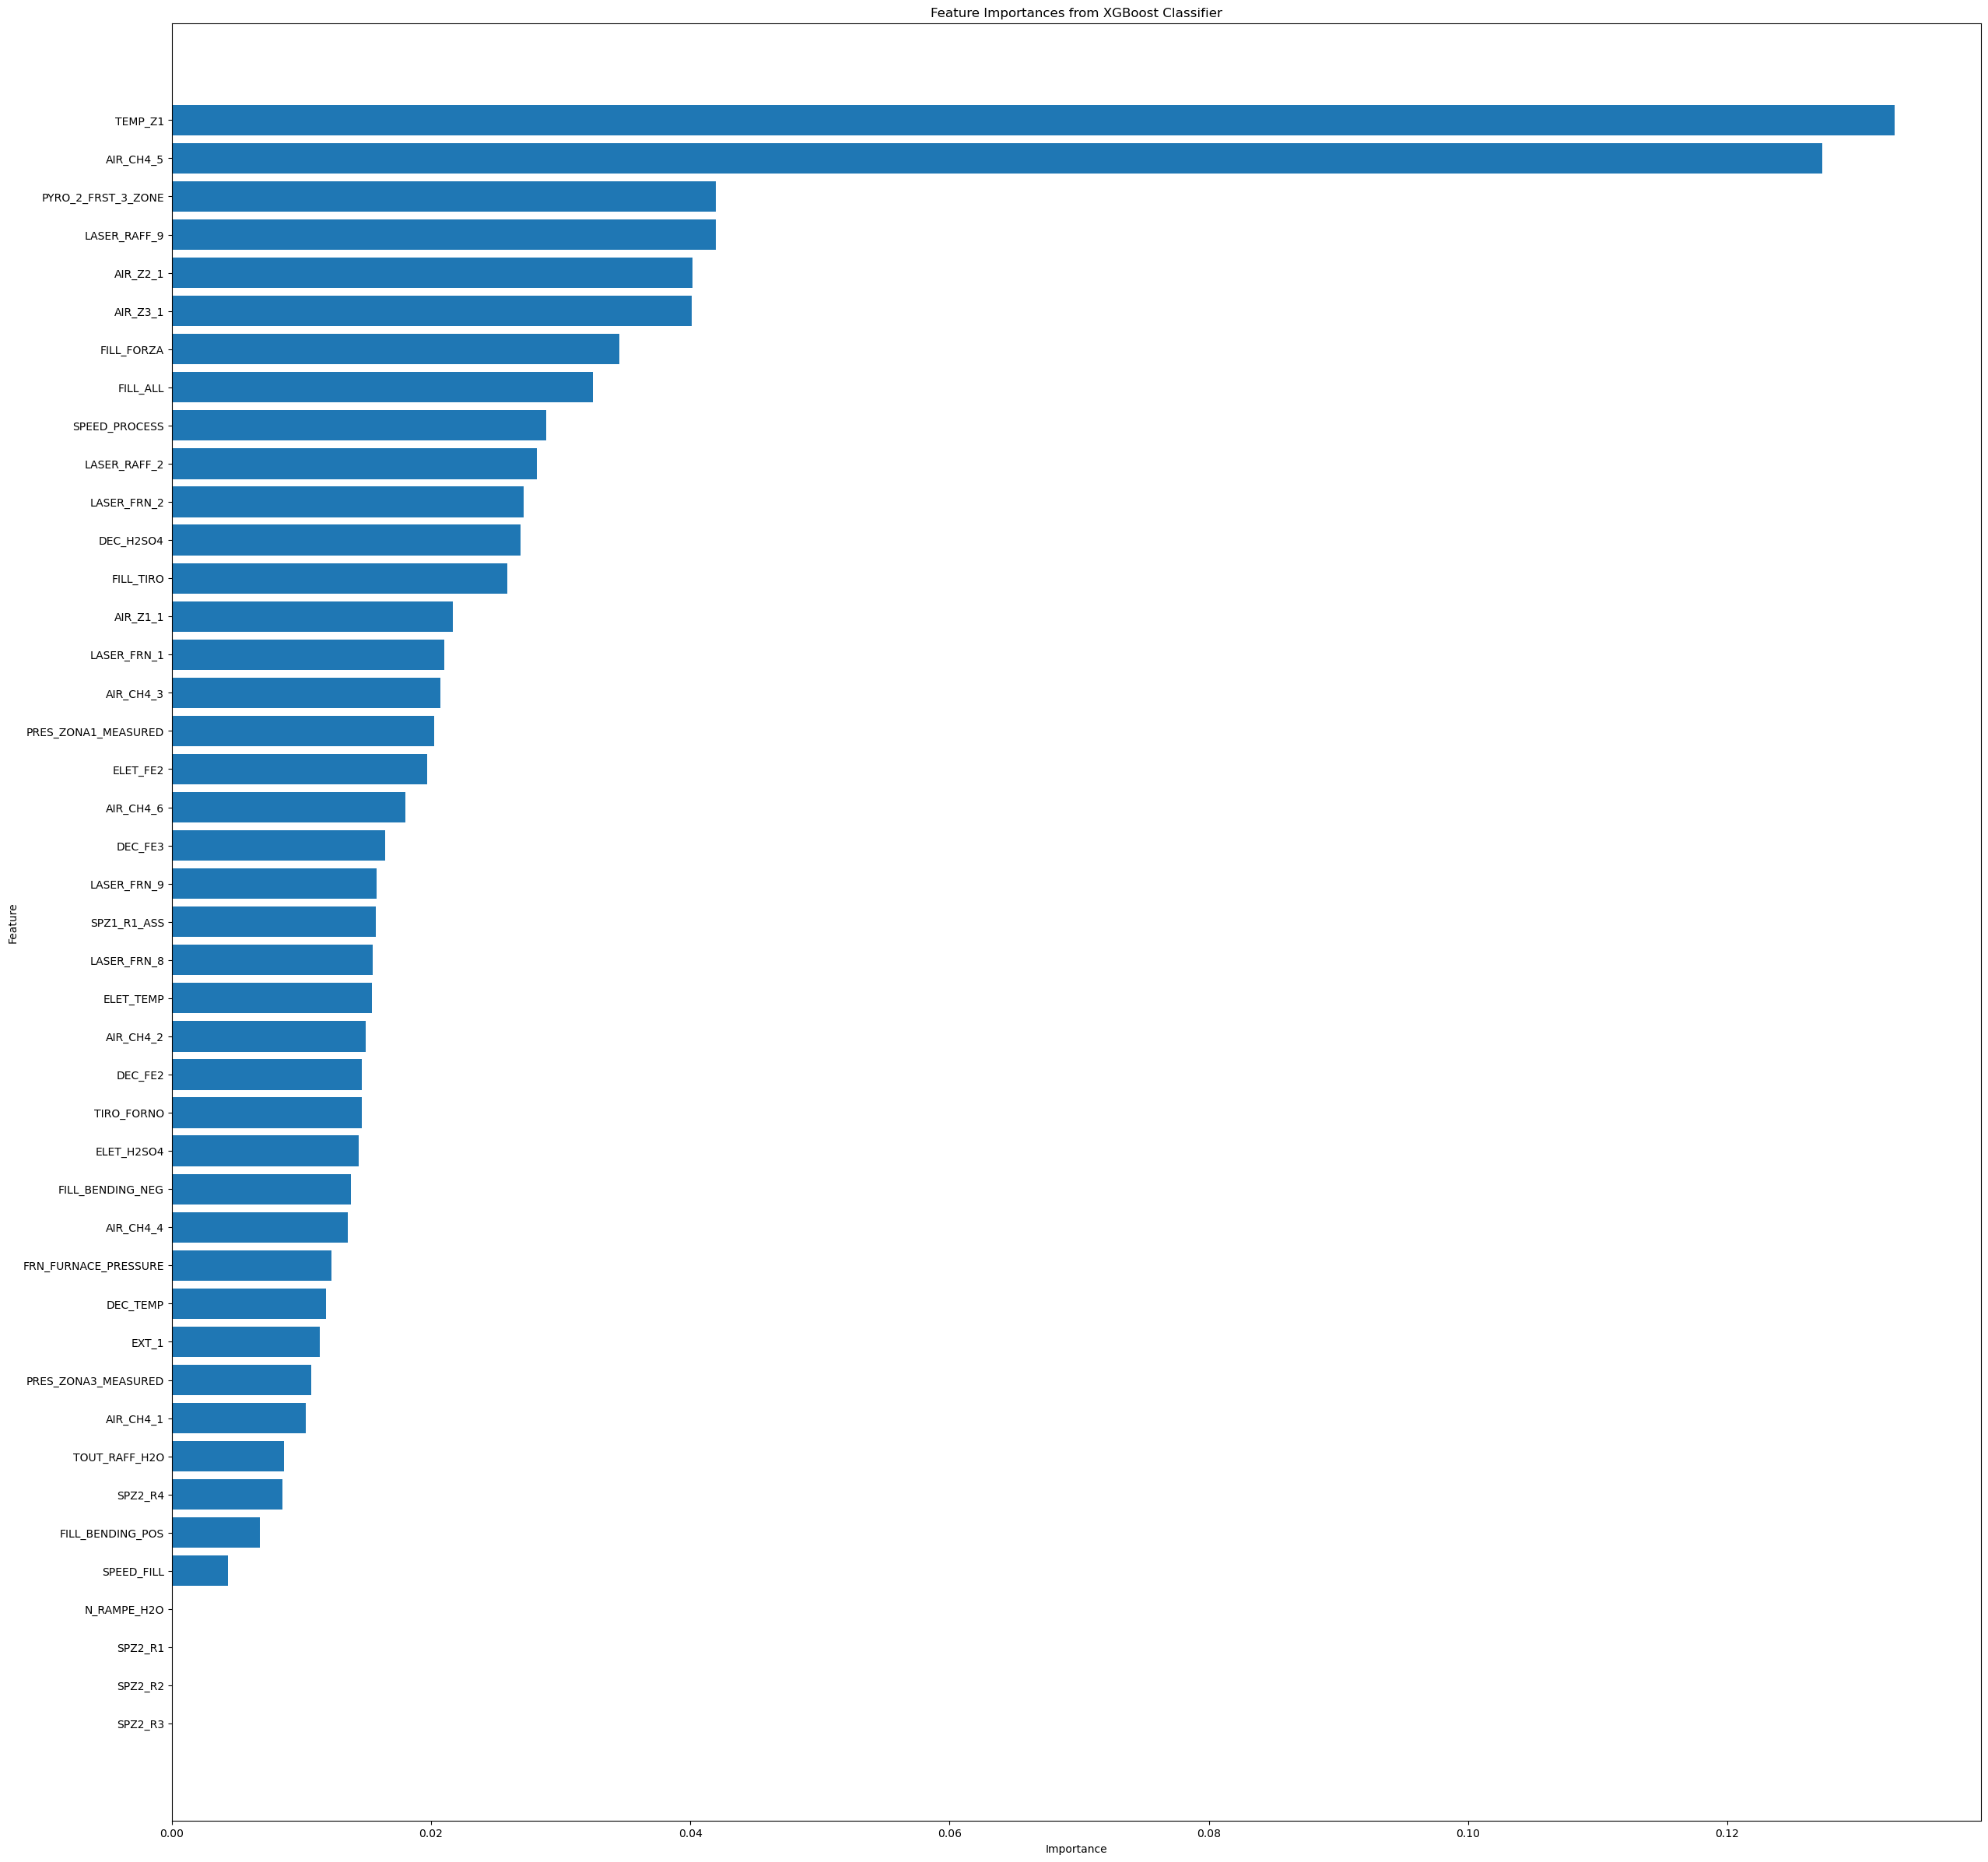

In [21]:
plt.figure(figsize=(30, 30))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost Classifier')
plt.gca().invert_yaxis()
plt.show()

In [22]:
defects_df = dropped_df[dropped_df['DEFECT'] == 1]
print(defects_df.shape)
no_defects_df = dropped_df[dropped_df['DEFECT'] == 0]
print(no_defects_df.shape)

(96246, 117)
(164392, 117)


In [23]:
print(no_defects_df['TEMP_Z1'].min())
print(no_defects_df['TEMP_Z1'].max())
print(no_defects_df['TEMP_Z1'].mean())
print(no_defects_df['TEMP_Z1'].median())
print(no_defects_df['TEMP_Z1'].mode())

83.953845
1322.26875
1222.949699673847
1237.5766024999998
0    1236.7125
Name: TEMP_Z1, dtype: float64


In [24]:
print(defects_df['TEMP_Z1'].min())
print(defects_df['TEMP_Z1'].max())
print(defects_df['TEMP_Z1'].mean())
print(defects_df['TEMP_Z1'].median())
print(defects_df['TEMP_Z1'].mode())

267.917625
1320.54375
1260.482507458523
1269.632813
0    1270.395
Name: TEMP_Z1, dtype: float64


/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/1894614844.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df['TEMP_Z1'], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/1894614844.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df['TEMP_Z1'], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

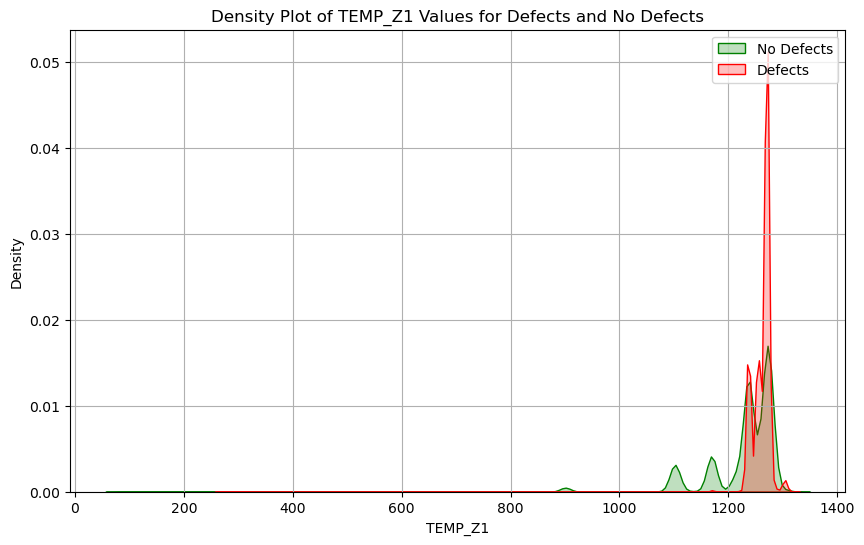

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(no_defects_df['TEMP_Z1'], shade=True, color='green', label='No Defects')
sns.kdeplot(defects_df['TEMP_Z1'], shade=True, color='red', label='Defects')
plt.title('Density Plot of TEMP_Z1 Values for Defects and No Defects')
plt.xlabel('TEMP_Z1')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/2794491067.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df['AIR_CH4_5'], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/2794491067.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df['AIR_CH4_5'], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

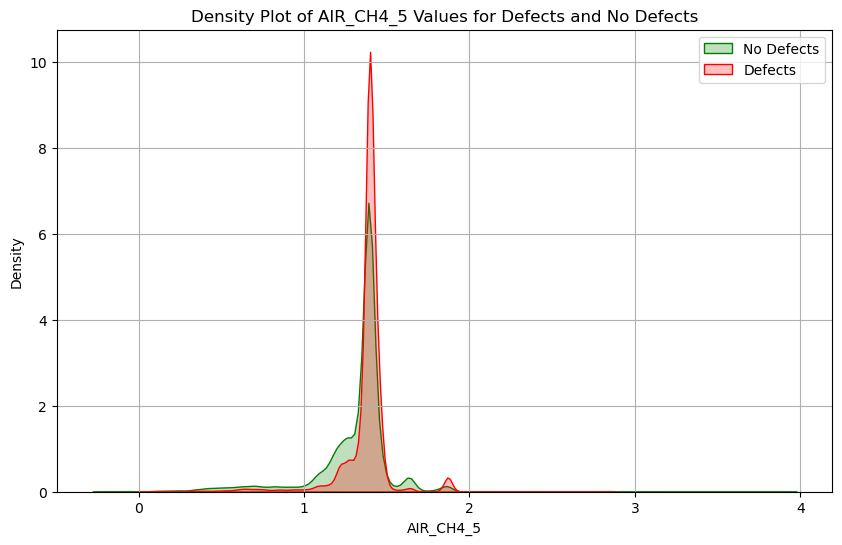

In [26]:
plt.figure(figsize=(10, 6))
sns.kdeplot(no_defects_df['AIR_CH4_5'], shade=True, color='green', label='No Defects')
sns.kdeplot(defects_df['AIR_CH4_5'], shade=True, color='red', label='Defects')
plt.title('Density Plot of AIR_CH4_5 Values for Defects and No Defects')
plt.xlabel('AIR_CH4_5')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/699242228.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df['PYRO_2_FRST_3_ZONE'], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/699242228.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df['PYRO_2_FRST_3_ZONE'], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: F

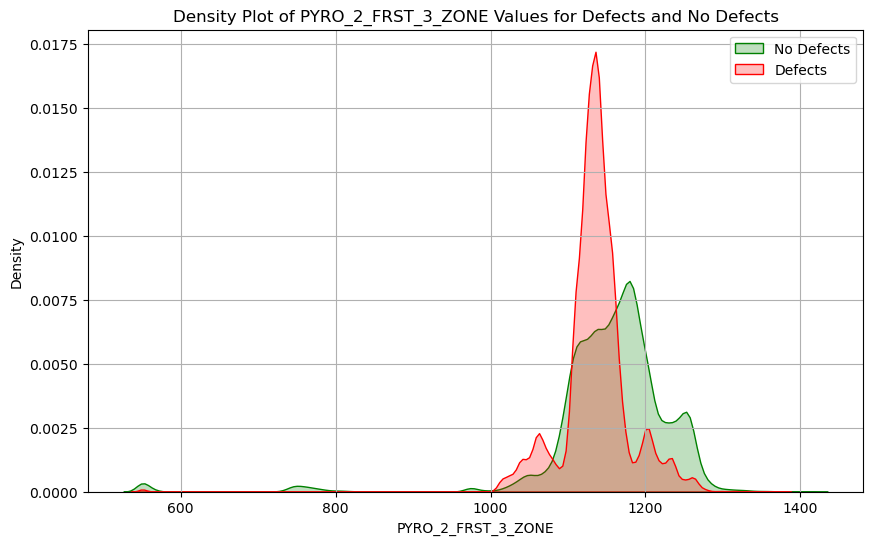

In [28]:
plt.figure(figsize=(10, 6))
sns.kdeplot(no_defects_df['PYRO_2_FRST_3_ZONE'], shade=True, color='green', label='No Defects')
sns.kdeplot(defects_df['PYRO_2_FRST_3_ZONE'], shade=True, color='red', label='Defects')
plt.title('Density Plot of PYRO_2_FRST_3_ZONE Values for Defects and No Defects')
plt.xlabel('PYRO_2_FRST_3_ZONE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/2790888418.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df['LASER_RAFF_9'], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/2790888418.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df['LASER_RAFF_9'], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarni

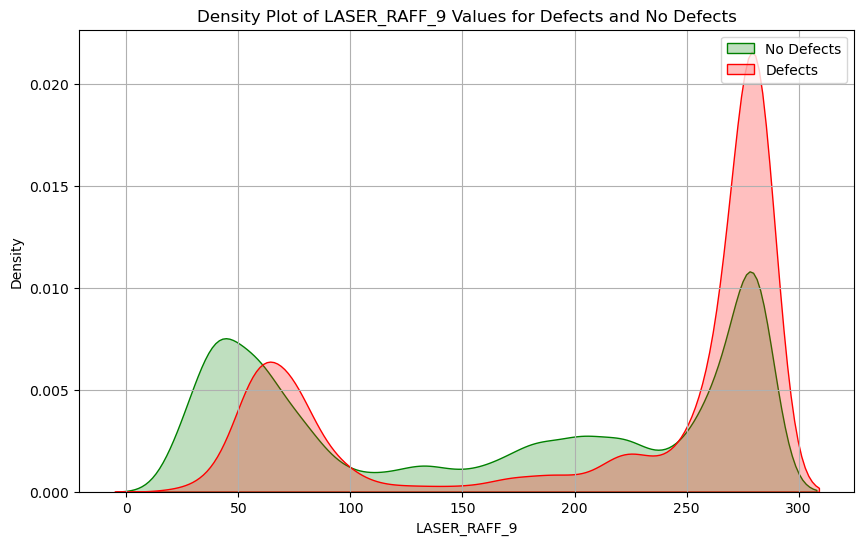

In [29]:
plt.figure(figsize=(10, 6))
sns.kdeplot(no_defects_df['LASER_RAFF_9'], shade=True, color='green', label='No Defects')
sns.kdeplot(defects_df['LASER_RAFF_9'], shade=True, color='red', label='Defects')
plt.title('Density Plot of LASER_RAFF_9 Values for Defects and No Defects')
plt.xlabel('LASER_RAFF_9')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/1965871045.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df['AIR_Z2_1'], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/1965871045.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df['AIR_Z2_1'], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_

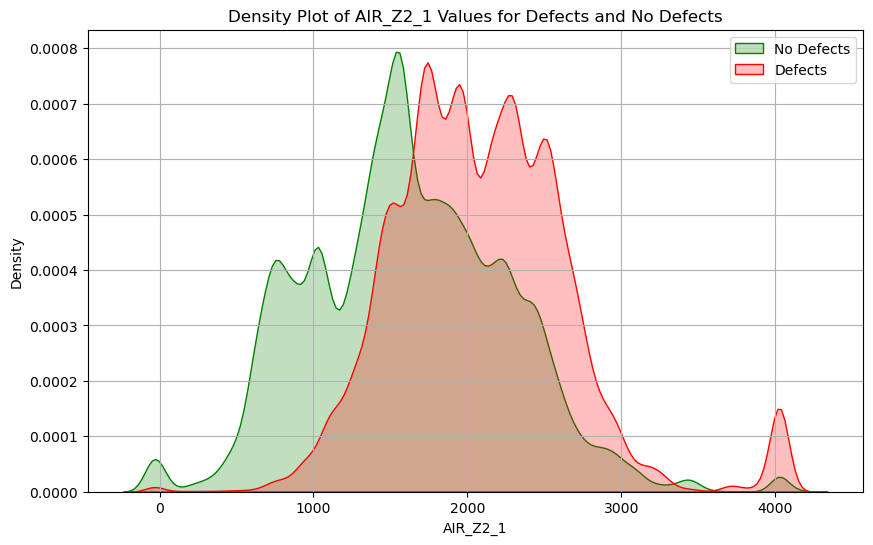

In [30]:
plt.figure(figsize=(10, 6))
sns.kdeplot(no_defects_df['AIR_Z2_1'], shade=True, color='green', label='No Defects')
sns.kdeplot(defects_df['AIR_Z2_1'], shade=True, color='red', label='Defects')
plt.title('Density Plot of AIR_Z2_1 Values for Defects and No Defects')
plt.xlabel('AIR_Z2_1')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/2074440674.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df['AIR_Z3_1'], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_88702/2074440674.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df['AIR_Z3_1'], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_

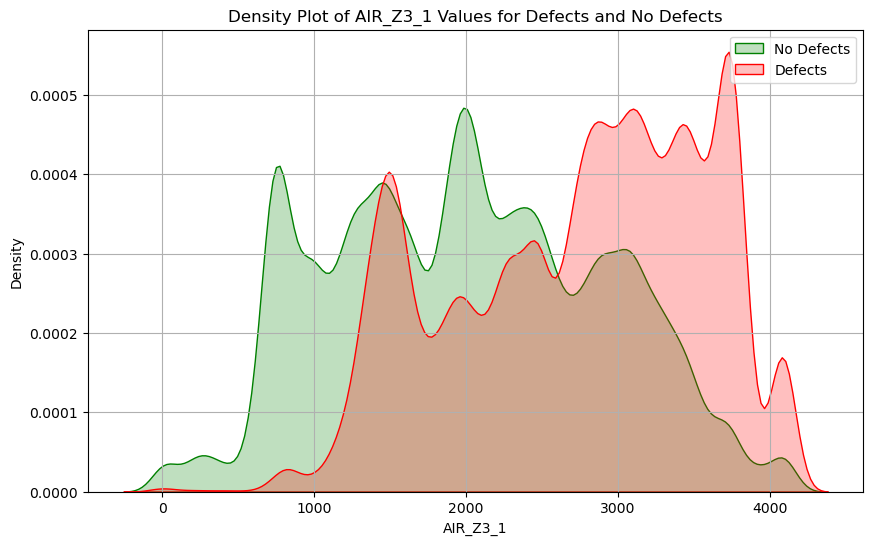

In [31]:
plt.figure(figsize=(10, 6))
sns.kdeplot(no_defects_df['AIR_Z3_1'], shade=True, color='green', label='No Defects')
sns.kdeplot(defects_df['AIR_Z3_1'], shade=True, color='red', label='Defects')
plt.title('Density Plot of AIR_Z3_1 Values for Defects and No Defects')
plt.xlabel('AIR_Z3_1')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
def_1 = dropped_df[dropped_df['DIF_TIPO_1'] == 1]
non_def_1 = dropped_df[dropped_df['DIF_TIPO_1'] == 0]
print(non_def_1['LASER_RAFF_6'].mean())
print(def_1['LASER_RAFF_6'].mean())

243.55397941882543
266.455003962909


In [57]:
def_2 = dropped_df[dropped_df['DIF_TIPO_2'] == 1]
non_def_2 = dropped_df[dropped_df['DIF_TIPO_2'] == 0]
print(non_def_2['LASER_RAFF_6'].mean())
print(def_2['LASER_RAFF_6'].mean())

243.76293809956337
253.78003338707074


In [58]:
def_3 = dropped_df[dropped_df['DIF_TIPO_3'] == 1]
non_def_3 = dropped_df[dropped_df['DIF_TIPO_3'] == 0]
print(non_def_3['LASER_RAFF_6'].mean())
print(def_3['LASER_RAFF_6'].mean())

234.42316754044873
266.7777068011678


In [59]:
def_4 = dropped_df[dropped_df['DIF_TIPO_4'] == 1]
non_def_4 = dropped_df[dropped_df['DIF_TIPO_4'] == 0]
print(non_def_4['LASER_RAFF_6'].mean())
print(def_4['LASER_RAFF_6'].mean())

239.31835299109198
265.4966958483772


In [60]:
def_5 = dropped_df[dropped_df['DIF_TIPO_5'] == 1]
non_def_5 = dropped_df[dropped_df['DIF_TIPO_5'] == 0]
print(non_def_5['LASER_RAFF_6'].mean())
print(def_5['LASER_RAFF_6'].mean())

243.47899603918756
267.57097861961074


In [61]:
def_6 = dropped_df[dropped_df['DIF_TIPO_6'] == 1]
non_def_6 = dropped_df[dropped_df['DIF_TIPO_6'] == 0]
print(non_def_6['LASER_RAFF_6'].mean())
print(def_6['LASER_RAFF_6'].mean())

243.35988208828002
272.52288764408326
